code from: https://rasterio.readthedocs.io/en/latest/topics/reading.html

### Merging Raster Imagery

In [21]:
import rasterio
from osgeo import gdal
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import glob
import os
import xarray as xr
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np



%matplotlib inline


# Data Exploration

### Import the data

In [ ]:
#list of test data files
PIREDD_2013 = '/Users/joycelynlongdon/Desktop/Cambridge/CambridgeCoding/MRES/Data/PIREDD_Test_Data/PIREDD_2013_Test_Date_Merged.tif'
PIREDD_2014 = '/Users/joycelynlongdon/Desktop/Cambridge/CambridgeCoding/MRES/Data/PIREDD_Test_Data/PIREDD_2014_Test_Data_Merged.tif'
PIREDD_2015 = '/Users/joycelynlongdon/Desktop/Cambridge/CambridgeCoding/MRES/Data/PIREDD_Test_Data/PIREDD_2015_Test_Data_Merged.tif'
PIREDD_2016 = '/Users/joycelynlongdon/Desktop/Cambridge/CambridgeCoding/MRES/Data/PIREDD_Test_Data/PIREDD_2016_Test_Data_Merged.tif'
PIREDD_2017 = '/Users/joycelynlongdon/Desktop/Cambridge/CambridgeCoding/MRES/Data/PIREDD_Test_Data/PIREDD_2017_Test_Data_Merged.tif'
PIREDD_2018 = '/Users/joycelynlongdon/Desktop/Cambridge/CambridgeCoding/MRES/Data/PIREDD_Test_Data/PIREDD_2018_Test_Data_Merged.tif'
PIREDD_2019 = '/Users/joycelynlongdon/Desktop/Cambridge/CambridgeCoding/MRES/Data/PIREDD_Test_Data/PIREDD_2019_Test_Data_Merged.tif'


#routine to visualise a given year and its bandsfor data in test_data:
src = rasterio.open(PIREDD_2019)
array = src.read()
band_1 = src.read(1)
band_2 = src.read(2)
band_3 = src.read(3)
band_4 = src.read(4)
band_5 = src.read(5)    
band_6 = src.read(6)
band_7 = src.read(7)
src

### Visualise  the Data

In [ ]:
#plot band images
fig, ((ax1, ax2, ax3 , ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize = (12,4)) 
fig.suptitle('Visuallising Test Data Bands')
ax1.title.set_text('Band 1')
ax2.title.set_text('Band 2')
ax3.title.set_text('Band 3')
ax4.title.set_text('Band 4')
ax5.title.set_text('Band 5')
ax6.title.set_text('Band 6')
ax7.title.set_text('Band 7')
ax8.title.set_text('Band 8')
show(band_1, ax=ax1)
show(band_2, ax=ax2)
show(band_3, ax=ax3)
show(band_4, ax=ax4)
show(band_5, ax=ax5)
show(band_6, ax=ax6)
show(band_7, ax=ax7)
show(src, ax=ax8)


### Read MetaData

In [ ]:
# How many bands does this image have?
num_bands = src.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = src.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = src.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = src.crs
print('Image projection:')
print(proj)

In [ ]:
print(array)

### Visualise Training Tiles

In [15]:
#list of test data files
training_tile = '/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/training_tiles/merged_l8_train_data.tif'

#routine to visualise a given year and its bandsfor data in test_data:
src = rasterio.open(training_tile)
array = src.read()
src

<open DatasetReader name='/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/training_tiles/merged_l8_train_data.tif' mode='r'>

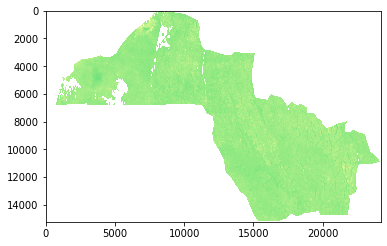

<AxesSubplot:>

In [17]:
#visualise one band
band_1 = src.read(1)
show(band_1, cmap='terrain')

In [27]:
image_read_masked = np.ma.masked_array(band_1, mask=(band_1 == 0))

In [18]:
# Read the grid values into numpy arrays
red = src.read(3)
green = src.read(2)
blue = src.read(1)

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

Normalized bands
nan - nan mean: nan
nan - nan mean: nan
nan - nan mean: nan


### Landcover Practice


In [3]:
training_polygon = '/Users/joycelynlongdon/Desktop/Cambridge/CambridgeCoding/MRES/Data/GeoJSONS/DRC_Training_Polygon.geojson'
studyRegion = gpd.GeoDataFrame({'geometry': training_polygon}, index=[0], crs=from_epsg(4326))

AttributeError: module 'geopandas' has no attribute 'GeoDataFrame'

In [ ]:
# check out the labels and convert them to values
print(f"There are {len(classes)} classes.")
print(classes)

class_value_to_label = {class_val: row.LCCOwnLabel for class_val, row in classes.iterrows()}

In [ ]:
#prepping data for our region of interest
training_polygon = '/Users/joycelynlongdon/Desktop/Cambridge/CambridgeCoding/MRES/Data/GeoJSONS/DRC_Training_Polygon.geojson'

def clip_and_reproject(xrdata, clip_geometry=training_polygon, to_crs=None, x_res=300, y_res=300):

    if clip_geometry is not None:
        clipped_data = xrdata.rio.clip(clip_geometry)
    else:
        clipped_data = xrdata

    if to_crs is not None:
        reprojected_data = clipped_data.rio.reproject(to_crs, resolution=(x_res, y_res))
    else:
        reprojected_data = clipped_data

    return reprojected_data

In [ ]:
# Loading ESA CCI land cover raster data
training_polygon = '/Users/joycelynlongdon/Desktop/Cambridge/CambridgeCoding/MRES/Data/GeoJSONS/DRC_Training_Polygon.geojson'
ESA_CCI_2013 = LC_src.clip(training_polygon)
              

In [ ]:
plt.imshow(ESA_CCI_2013)